In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import statsmodels.api as sm
#import multiprocessing as mp
import matplotlib.pyplot as plt
from __future__ import division
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

/Users/jenchieh/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
strips = pd.read_excel('./HW1_data.xls')
strips.columns = ['Mat', 'Px']

In [3]:
def spot_rate(t, P, APR=True):
    
    r = (100 / P) ** (1 / t) - 1
    if APR: #else: EAR
        r = 2 * ((1 + r) ** 0.5 - 1)
    return r

def par_yield(T, DF):
    
    # semiannually compounded  
    t = np.linspace(0.5, T, int(2*T))
    
    return 2 * (1 - DF(T)) / np.sum(DF(t))

def fw_rate(t, dt, DF):
    
    return ((DF(t) / DF(t + dt)) - 1 ) * (1/dt)

def coupon_bond_P(c, T, DF):
    
    return (sum([c / 2 * DF(t) for t in np.linspace(0.5, T, int(2 * T))]) + DF(T)) * 100

def coupon_bond_YTM(c, T, DF):
    P = coupon_bond_P(c, T, DF) / 100
    ytm = lambda y: sum([c / 2 * (1 + y / 2) ** (-i) for i in range(1, int(2 * T))]) + (1 + c/2) * (1 + y / 2) ** (-2 * T) - P

    return opt.fsolve(ytm, c)

## Polynomial-based Yield Curve

In [4]:
lnZ = np.log(strips.Px / 100)
X = pd.concat([strips.Mat**i for i in range(1,6)], axis=1)
X.columns = ['pwr_' + str(i) for i in range(1,6)]

model = sm.OLS(lnZ, X)
poly_res = model.fit()

p = np.polynomial.Polynomial(np.r_[0, poly_res.params.values])
poly_DF = lambda t: np.exp(p(t))

ts = np.linspace(1, 30, 30)

In [5]:
def Convexity(c, T, DF, k=2):
    
    y, P = coupon_bond_YTM(c, T, DF), coupon_bond_P(c, T, DF) / 100
    C = sum([(i * i + i) / (k * k) * (c / k) * (1 + y / k) ** (-i) for i in range(1, int(k * T) + 1)])
    return float(C / (P * (1 + y / k)**2))

def Mac_Duration(c, T, DF, k=2):
    
    y, P = coupon_bond_YTM(c, T, DF), coupon_bond_P(c, T, DF) / 100
    d = sum([i / k *(c / k) * (1 + y / k) ** (-i) for i in range(1, int(k * T) + 1)]) + \
    T * (1 + y / k) ** (-k * T)

    return float(d / P)

## Par Bonds: 1 - 30 years

In [6]:
y_par = [par_yield(t, poly_DF) for t in ts]
mac_D_par = [Mac_Duration(par, t, poly_DF) for t, par in zip(ts, y_par)]
mod_D_par = [D / (1 + par / 2) for D, par in zip(mac_D_par, y_par)]

DV01 = [D / 100 for D in mod_D_par]
Cvx_par = [Convexity(par, t, poly_DF) for t, par in zip(ts, y_par)]

par_bonds = pd.DataFrame({'Mac Duration': mac_D_par,
                          'Mod Duration': mod_D_par,
                          'DV01': DV01,
                          'Convexity': Cvx_par},
                         index=range(1, 31))
par_bonds

,Convexity,DV01,Mac Duration,Mod Duration
1,0.031907,0.009751,0.991645,0.975075
2,0.160220,0.019152,1.948843,1.915226
3,0.449304,0.028187,2.869727,2.818686
4,0.961381,0.036841,3.752819,3.684101
5,1.754460,0.045106,4.597136,4.510622
6,2.880481,0.052979,5.402231,5.297946
7,4.383868,0.060463,6.168206,6.046312
8,6.300617,0.067565,6.895685,6.756473
9,8.657935,0.074296,7.585761,7.429637
10,11.474399,0.080674,8.239926,8.067395


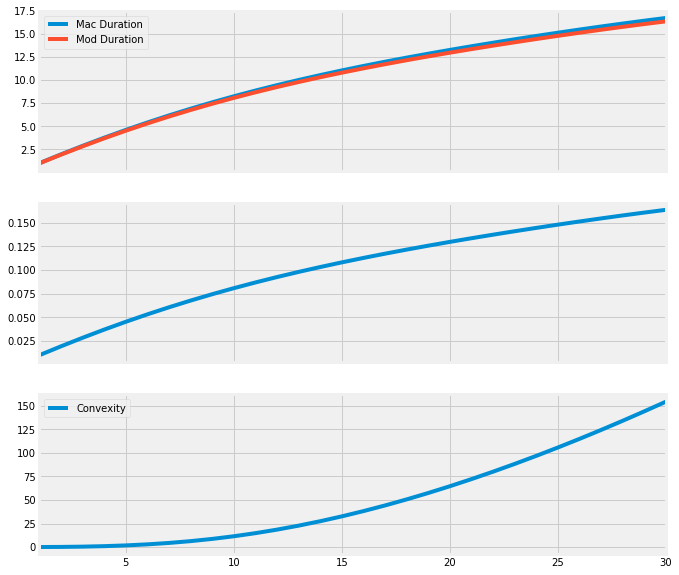

In [7]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10, 10))

par_bonds[['Mac Duration', 'Mod Duration']].plot(ax=ax[0])
par_bonds['DV01'].plot(ax=ax[1])
par_bonds['Convexity'].plot(ax=ax[2])

plt.legend()

## Coupon Bonds: 2% & 12%, 1 - 30 years

,12%,2%
1,0.9728,0.9950
2,1.8496,1.9700
3,2.6509,2.9246
4,3.3908,3.8584
5,4.0795,4.7709
6,4.7245,5.6615
7,5.3316,6.5293
8,5.9051,7.3738
9,6.4487,8.1942
10,6.9655,8.9899


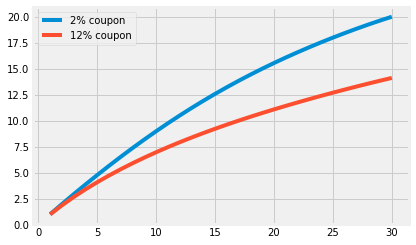

In [8]:
mac_D_2 = [Mac_Duration(0.02, t, poly_DF) for t in ts]
mac_D_12 = [Mac_Duration(0.12, t, poly_DF) for t in ts]

plt.plot(ts, mac_D_2, label='2% coupon')
plt.plot(ts, mac_D_12, label='12% coupon')

plt.legend()

pd.DataFrame({'2%': mac_D_2, '12%': mac_D_12}, index=range(1, 31)).round(4)

## Price Change: Duration approximation

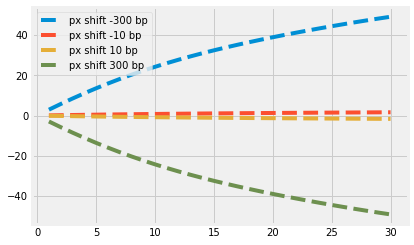

In [10]:
bps_shift = [-300, -10, 10, 300]
ts = np.linspace(1, 30, 30)

Duration_appox_ = {bps: [-D * 100 * bps / 10000 for D in mod_D_par] for bps in bps_shift}

for s in bps_shift:
    plt.plot(ts, Duration_appox_[s], ls='--', label='px shift %.f bp'%s)
    
plt.legend()

## Price Change: Convexity approximation

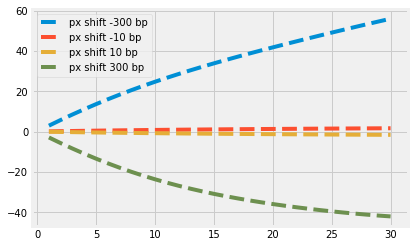

In [11]:
Convexity_appox_ = {bps: [(-D * bps / 10000 + 0.5 * C * (bps / 10000) ** 2) * 100 for C, D in zip(Cvx_par, mod_D_par)] \
                    for bps in bps_shift}

for s in bps_shift:
    plt.plot(ts, Convexity_appox_[s], ls='--', label='px shift %.f bp'%s)
    
plt.legend()

## Exact Price Change

In [12]:
def DF_parallel_shift(DF, shift, k=2):
    
    def shifted_DF(t): 
        spot = spot_rate(t, DF(t)*100)
        return (1 + (spot + shift) / k) ** (-t * k)
    
    return shifted_DF

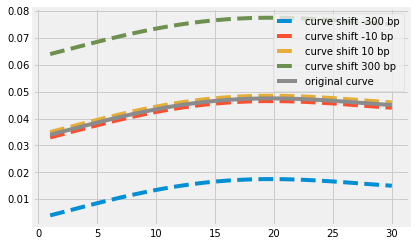

In [13]:
spot_curve = spot_rate(ts, poly_DF(ts)*100)
shifted_DF = {bps: DF_parallel_shift(poly_DF, bps / 10000) for bps in bps_shift}

spot_curve_ = {bps: spot_rate(ts, shifted_DF[bps](ts)*100) for bps in shifted_DF.keys()}

for s in bps_shift:
    plt.plot(ts, spot_curve_[s], ls='--', label='curve shift %.f bp'%s)

plt.plot(ts, spot_curve, label='original curve')
plt.legend()

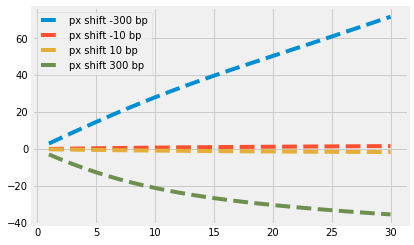

In [14]:
#par_price = [coupon_bond_P(y, t, poly_DF) for y, t in zip(y_par, ts)]
par_dp_ = {bps: [coupon_bond_P(y, t, shifted_DF[bps]) - 100 for y, t in zip(y_par, ts)]for bps in shifted_DF.keys()}

for s in bps_shift:
    plt.plot(ts, par_dp_[s], ls='--', label='px shift %.f bp'%s)
    
plt.legend()

## Comparison

In [15]:
data_dict = {}
for bps in bps_shift:
    data_dict[(bps, 'Duration')] = Duration_appox_[bps]
    data_dict[(bps, 'Convexity')] = Convexity_appox_[bps]
    data_dict[(bps, 'Exact')] = par_dp_[bps]

px_change = pd.DataFrame(data_dict, index=range(1, 31))
px_change

-300                            -10                            10   \
    Convexity   Duration      Exact Convexity  Duration     Exact Convexity   
1    2.926661   2.925225   2.991045  0.097509  0.097507  0.097579 -0.097506   
2    5.752889   5.745679   5.961761  0.191531  0.191523  0.191752 -0.191515   
3    8.476275   8.456057   8.902110  0.281891  0.281869  0.282322 -0.281846   
4   11.095564  11.052302  11.802545  0.368458  0.368410  0.369130 -0.368362   
5   13.610817  13.531867  14.654431  0.451150  0.451062  0.452058 -0.450974   
6   16.023459  15.893838  17.450402  0.529939  0.529795  0.531040 -0.529651   
7   18.336209  18.138935  20.184608  0.604850  0.604631  0.606066 -0.604412   
8   20.552946  20.269418  22.852889  0.675962  0.675647  0.677176 -0.675332   
9   22.678517  22.288910  25.452851  0.743397  0.742964  0.744463 -0.742531   
10  24.718533  24.202185  27.983867  0.807313  0.806739  0.808067 -0.806166   
11  26.679139  26.014914  30.447010  0.867902  0.867164  0.868168 -0.866426   
12  28.566813  27.733421  32.844927  0.925373  0.924447  0.924978 -0.923521   
13  30.388169  29.364436  35.181670  0.979952  0.978815  0.978734 -0.977677   
14  32.149790  30.914875  37.462496  1.031868  1.030496  1.029692 -1.029124   
15  33.858089  32.391648  39.693647  1.081351  1.079722  1.078116 -1.078092   
16  35.519190  33.801488  41.882111  1.128625  1.126716  1.124273 -1.124808   
17  37.138844  35.150825  44.035390  1.173903  1.171694  1.168427 -1.169485   
18  38.722352  36.445672  46.161255  1.217385  1.214856  1.210833 -1.212326   
19  40.274513  37.691541  48.267504  1.259255  1.256385  1.251729 -1.253515   
20  41.799578  38.893378  50.361717  1.299675  1.296446  1.291335 -1.293217   
21  43.301213  40.055509  52.451009  1.338790  1.335184  1.329844 -1.331577   
22  44.782458  41.181590  54.541761  1.376721  1.372720  1.367425 -1.368719   
23  46.245691  42.274566  56.639337  1.413565  1.409152  1.404213 -1.404740   
24  47.692581  43.336631  58.747777  1.449394  1.444554  1.440305 -1.439714   
25  49.124032  44.369173  60.869446  1.484256  1.478972  1.475761 -1.473689   
26  50.540126  45.372732  63.004651  1.518166  1.512424  1.510593 -1.506683   
27  51.940047  46.346946  65.151209  1.551113  1.544898  1.544768 -1.538684   
28  53.322015  47.290494  67.303979  1.583052  1.576350  1.578196 -1.569648   
29  54.683208  48.201063  69.454364  1.613904  1.606702  1.610729 -1.599500   
30  56.019703  49.075312  71.589805  1.643560  1.635844  1.642159 -1.628128   

                              300                        
    Duration     Exact  Convexity   Duration      Exact  
1  -0.097507 -0.097436  -2.923789  -2.925225  -2.861927  
2  -0.191523 -0.191285  -5.738469  -5.745679  -5.541652  
3  -0.281869 -0.281368  -8.435838  -8.456057  -8.042072  
4  -0.368410 -0.367538 -11.009039 -11.052302 -10.367059  
5  -0.451062 -0.449695 -13.452916 -13.531867 -12.521631  
6  -0.529795 -0.527788 -15.764216 -15.893838 -14.511998  
7  -0.604631 -0.601820 -17.941661 -18.138935 -16.345508  
8  -0.675647 -0.671849 -19.985890 -20.269418 -18.030527  
9  -0.742964 -0.737980 -21.899303 -22.288910 -19.576251  
10 -0.806739 -0.800366 -23.685837 -24.202185 -20.992501  
11 -0.867164 -0.859195 -25.350689 -26.014914 -22.289495  
12 -0.924447 -0.914691 -26.900029 -27.733421 -23.477623  
13 -0.978815 -0.967098 -28.340703 -29.364436 -24.567236  
14 -1.030496 -1.016676 -29.679960 -30.914875 -25.568457  
15 -1.079722 -1.063695 -30.925206 -32.391648 -26.491012  
16 -1.126716 -1.108426 -32.083786 -33.801488 -27.344098  
17 -1.171694 -1.151134 -33.162806 -35.150825 -28.136274  
18 -1.214856 -1.192072 -34.168991 -36.445672 -28.875376  
19 -1.256385 -1.231481 -35.108569 -37.691541 -29.568461  
20 -1.296446 -1.269578 -35.987179 -38.893378 -30.221763  
21 -1.335184 -1.306558 -36.809805 -40.055509 -30.840670  
22 -1.372720 -1.342585 -37.580721 -41.181590 -31.429702  
23 -1.409152 -1.377793 -38.303442 -42.274566 -31.992503  
24 -1.444554 -1.412282 -38.980

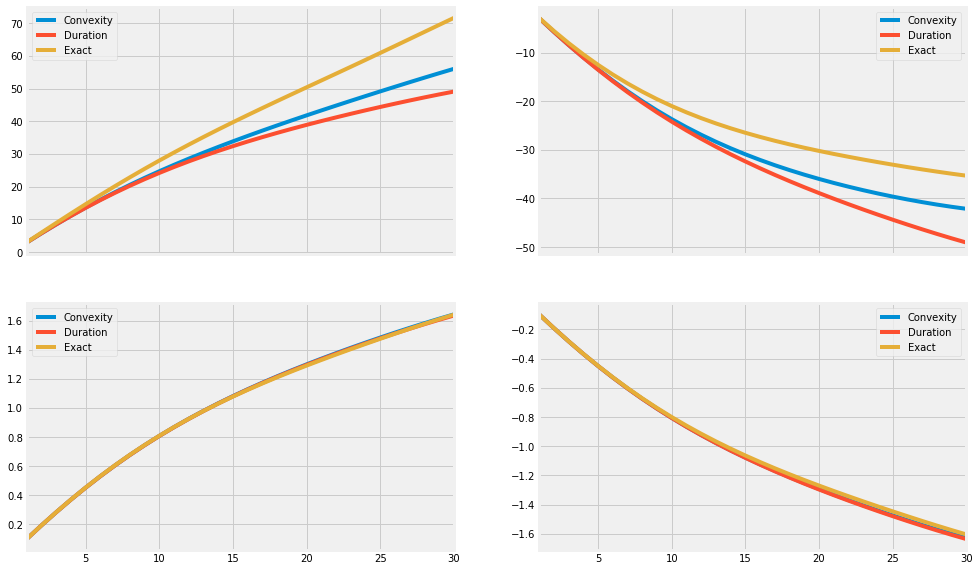

In [16]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(15, 10))
px_change[-300].plot(ax=ax[0][0])
px_change[300].plot(ax=ax[0][1])
px_change[-10].plot(ax=ax[1][0])
px_change[10].plot(ax=ax[1][1])